## Step 1: Import Libraries

In [1]:
# Feature extraction
import librosa, os, csv  # librosa ver 0.7.0

# Exploratory Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle

# Model
import keras

Using TensorFlow backend.


## Step 2: Import Dataset

**Source:** [GTZAN Genre Collection](http://marsyas.info/downloads/datasets.html)

In [2]:
# Download GTZAN genre collection
url = "http://opihi.cs.uvic.ca/sound/genres.tar.gz"
zip_file = keras.utils.get_file(fname="genres.tar.gz",
                                origin=url,
                                extract=True)

In [3]:
base_dir = os.path.join(os.path.dirname(zip_file), 'genres')
CLIP_DUR = 30
genres = "blues classical country disco hiphop jazz metal pop reggae rock".split()

The dataset has following directory structure. There are 100 audio clips for each of the 10 genres. Each clip has a duration of 30 secs.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;">
<b>genres</b>
|__ <b>blues</b>: [blues.00000.au, blues.00001.au, ...]
|__ <b>classical</b>: [classical.00000.au, classical.00001.au, ...]
|__ <b>country</b>: [country.00000.au, country.00001.au, ...]
|__ <b>disco</b>: [disco.00000.au, disco.00001.au, ...]
|__ <b>hiphop</b>: [hiphop.00000.au, hiphop.00001.au, ...]
|__ <b>jazz</b>: [jazz.00000.au, jazz.00001.au, ...]
|__ <b>metal</b>: [metal.00000.au, metal.00001.au, ...]
|__ <b>pop</b>: [pop.00000.au, pop.00001.au, ...]
|__ <b>reggae</b>: [reggae.00000.au, reggae.00001.au, ...]
|__ <b>rock</b>: [rock.00000.au, rock.00001.au, ...]

In [4]:
def create_datafile(genres, segments=1):
    """
    PURPOSE:
    - Create csv file to save song features and genre labels.
    
    INPUTS:
    - genres = list of genres
    - segments = # of segments to be split from an audio clip (default=1)
    
    OUTPUTS:
    - data_file = name of data file
    """
    header = "filename chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate "
    for e in range(1, 21):
        header += f"mfcc{e} "
    header += "label "
    
    data_file = f"data_{segments}.csv"
    
    with open(data_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header.split())
        
    return data_file
        

In [5]:
def extract_features(data_file, genres, segments=1):
    """
    PURPOSE: 
    - Extract 26 features from each song segment. May create a bigger dataset by splitting a clip to more segments.
    
    INPUTS: 
    - data_file = csv file to keep song features
    - genres = list of genres
    - segments = # of segments to be split from an audio clip (default=1)    
    
    OUTPUTS:
    - Contents are appended to a data file. Nothing to return. 
    """
    duration = CLIP_DUR / segments
    
    for g in genres:
        print(f">>> Processing genre: {g}... ")
        dir_name = f"{base_dir}/{g}"
        
        for file in os.listdir(dir_name):
            clip_name = f"{dir_name}/{file}"
            
            for i in range(segments):
                # Extract song feature
                y, sr = librosa.load(clip_name, mono=True, offset=i*duration, duration=duration)
                chroma_stft = np.mean(librosa.feature.chroma_stft(y, sr)) # chromagram
                rms = np.mean(librosa.feature.rms(y)) # root mean square
                spec_cent = np.mean(librosa.feature.spectral_centroid(y, sr)) # spectral centroid
                spec_bw = np.mean(librosa.feature.spectral_bandwidth(y, sr)) # spectral bandwidth
                rolloff = np.mean(librosa.feature.spectral_rolloff(y, sr)) # roll-off frequency
                zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # zero-crossing rate
                mfcc = librosa.feature.mfcc(y, sr) # mel-frequency cepstral coefficients
                
                # Prepare row entries for data file
                row_contents = f"{file}.{i} {chroma_stft} {rms} {spec_cent} {spec_bw} {rolloff} {zcr} "
                for e in mfcc:
                    row_contents += f"{np.mean(e)} "
                row_contents += f"{g}"
                
                # Append row entries to data file
                with open(data_file, 'a', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow(row_contents.split())
                

In [6]:
segments = 6  # No. of segments split from an audio clip
DATA_FILE = f"data_{segments}.csv"

# Create data csv file
if not os.path.isfile(DATA_FILE):
    data_file = create_datafile(genres, segments=segments)
    extract_features(data_file, genres, segments=segments)

## Step 3: Perform EDA and Data Preprocessing

In [7]:
data = pd.read_csv(DATA_FILE)
data.head()

,filename,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00043.au.0,0.392800,0.131689,2196.867528,2348.170960,4961.110433,0.095405,-99.327637,101.836365,-12.666125,...,8.549444,-10.164876,4.610868,-15.176098,2.232718,-7.836296,-1.154607,-5.352743,4.344092,blues
1,blues.00043.au.1,0.413954,0.125603,2059.093878,2352.441272,4877.370199,0.076314,-115.263329,103.514122,-5.671316,...,5.362485,-8.288507,5.236783,-15.777740,1.477487,-6.700855,3.447752,-4.496523,2.588005,blues
2,blues.00043.au.2,0.405545,0.120685,1996.765542,2320.649333,4713.528442,0.076841,-121.895813,106.613914,-6.121138,...,6.923307,-9.306556,4.313902,-14.824131,5.111771,-4.786600,3.030149,-4.263715,1.498087,blues
3,blues.00043.au.3,0.368614,0.137185,2146.430563,2300.431734,4757.541911,0.094760,-98.623978,104.066345,-16.882162,...,9.727251,-8.378154,5.201426,-13.929669,4.069406,-8.593798,-3.793063,-3.450246,4.284850,blues
4,blues.00043.au.4,0.393270,0.123118,2252.344655,2407.258070,5229.627482,0.088725,-109.132904,93.573929,-11.297571,...,4.631731,-8.598670,7.542165,-18.475325,-2.737862,-7.514852,5.589629,-4.254663,6.947609,blues


In [8]:
data.describe()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.379193,0.130905,2200.719440,2242.120595,4569.322138,0.103075,-145.194473,100.635107,-9.772575,37.030378,...,-6.388140,4.822297,-5.091389,2.063904,-4.100576,1.369195,-4.143053,0.677577,-2.457085,-0.968103
std,0.087408,0.067745,740.456301,538.711889,1620.934827,0.044471,105.086643,33.823830,23.381922,17.444943,...,7.517313,7.298130,6.853646,5.778714,5.618595,5.396143,5.336721,4.766064,4.679195,4.801748
min,0.117847,0.001185,487.862737,674.455128,674.557495,0.013093,-641.650757,-7.814273,-99.599518,-29.330387,...,-35.756905,-20.579565,-29.327696,-21.975698,-24.266285,-26.419592,-22.621651,-21.090328,-23.166182,-25.340755
25%,0.318373,0.084714,1631.273918,1890.214732,3375.553894,0.068035,-201.680775,76.200109,-25.882419,24.491181,...,-11.920839,-0.467052,-10.042779,-1.788476,-7.965738,-2.146356,-7.769275,-2.274080,-5.403367,-3.717190
50%,0.384747,0.121859,2221.640357,2232.531415,4645.813497,0.098381,-120.527260,98.260422,-11.484080,37.762245,...,-6.224568,4.586287,-4.680457,2.163648,-3.988846,1.460567,-4.320455,0.675438,-2.648093,-1.089418
75%,0.440101,0.175969,2710.679971,2584.820550,5577.834829,0.132928,-70.209743,121.614105,5.673980,49.390400,...,-0.857739,10.471051,-0.205995,6.013171,-0.352852,4.922965,-0.776004,3.658338,0.348423,1.921408
max,0.733184,0.434151,5431.825689,3705.773762,9478.397624,0.321705,107.417488,246.746994,72.607841,84.865547,...,22.026119,28.878368,24.638369,31.220829,23.643862,30.160583,28.981445,26.916731,25.349804,28.228935


In [9]:
def preprocess_data(data):
    """
    PURPOSE: 
    - Create training and test datasets
    
    INPUT:
    - data: data file contents in Pandas DataFrame
    
    OUTPUTS:
    - scaler.pkl: Pickle file of trained scaler
    - encoder.pkl: Pickle file of trained encoder
    
    RETURNS:
    - X_train: Training dataset of input features
    - X_test: Test dataset of input features
    - y_train: Training dataset of labels
    - y_test: Test dataset of labels
    """
    
    # Separate features and labels
    features = data.iloc[:, 1:-1]
    labels = data.iloc[:, -1]
    
    # Standardize features to zero mean and unit variance
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(features))
    pickle.dump(scaler, open("scaler.pkl", "wb"))
    
    # Encode genre labels
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)
    pickle.dump(encoder, open("encoder.pkl", "wb"))
    
    # Divide data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = preprocess_data(data)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (5400, 26)
X_test: (600, 26)
y_train: (5400,)
y_test: (600,)


## Step 4: Build Classifier Model (Artificial Neural Network)

In [11]:
from keras.models import Sequential
from keras.layers import Dense

BATCH_SIZE = 50
EPOCHS = 30

classifier = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

classifier.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
classifier.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               6912      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 48,714
Trainable params: 48,714
Non-trainable params: 0
_________________________________________________________________


## Step 5: Perform Model Training and Evaluation

In [12]:
# Training
history = classifier.fit(X_train, y_train, BATCH_SIZE, EPOCHS, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 4860 samples, validate on 540 samples
Epoch 1/30
4860/4860 [==============================] - 1s 269us/step - loss: 1.5002 - acc: 0.4747 - val_loss: 1.1813 - val_acc: 0.6222
Epoch 2/30
4860/4860 [==============================] - 0s 84us/step - loss: 1.0099 - acc: 0.6549 - val_loss: 1.0010 - val_acc: 0.6685
Epoch 3/30
4860/4860 [==============================] - 1s 127us/step - loss: 0.8505 - acc: 0.7101 - val_loss: 0.8706 - val_acc: 0.7167
Epoch 4/30
4860/4860 [==============================] - 0s 91us/step - loss: 0.7415 - acc: 0.7488 - val_loss: 0.8324 - val_acc: 0.7093
Epoch 5/30
4860/4860 [==============================] - 0s 92us/step - loss: 0.6577 - acc: 0.7798 - val_loss: 0.7815 - val_acc: 0.7352
Epoch 6/30
4860/4860 [==============================] - 0s 88us/step - loss: 0.5807 - acc: 0.8025 - val_loss: 0.6938 - val_acc: 0.7630
Epoch 7/30
4860/4860 [==============================] - 0s 86us/step - loss: 0.5229 - acc: 0.

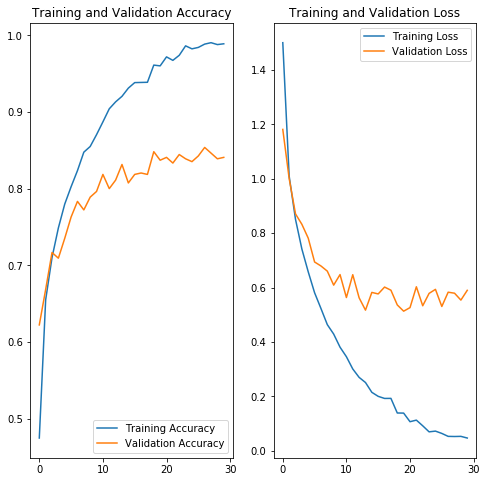

In [13]:
# Plot accurary/loss graphs
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [14]:
# Evaluation
classifier.evaluate(X_test, y_test)

600/600 [==============================] - 0s 41us/step


[0.48346625884373984, 0.8800000007947286]

## Step 6: Save Classifier for Distribution

In [15]:
# Save neural network structure
from pathlib import Path
model_structure = classifier.to_json()
f = Path("music_genre_classifier_structure.json")
f.write_text(model_structure)

# Save neural network's trained weights
classifier.save_weights("music_genre_classifier_weights.h5")  